**Install Dependencies and Load Dataset**

In this project, I build and evaluate a NER model, mainly using torch and torchtext libraries.

In [1]:
!pip install torchtext==0.6.0 #legacy 

import torchtext
import time
import torch
from torch import nn
from torch.optim import Adam
from torchtext.data import Field, BucketIterator
from torchtext.datasets import SequenceTaggingDataset
import matplotlib.pyplot as plt
import spacy
from collections import defaultdict, Counter
# For CRF layer, "from TorchCRF import CRF" is used, but its not implemented.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 150.8 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.2
    Uninstalling torchtext-0.11.2:
      Successfully uninstalled torchtext-0.11.2

[notice] A new release of pip available: 22.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


First custom function to read txt. files created. Since CoNNL-2003 dataset is used for different sequential labelling tasks too, files has 4 different values divided by spaces. These values are,
- Word Token
- POS tag
- Chunking tag
- NER tag

An example sentence as follows:

      EU NNP B-NP B-ORG
      rejects VBZ B-VP O
      German JJ B-NP B-MISC
      call NN I-NP O
      to TO B-VP O
      boycott VB I-VP O
      British JJ B-NP B-MISC
      lamb NN I-NP O
      . . O O


In [3]:
# from TorchCRF import CRF
def read_data(corpus_file, datafields):
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        words = []
        labels = []
        for line in f:
            line = line.strip()
            if not line:
                examples.append(torchtext.data.Example.fromlist([words, labels], datafields))
                words = []
                labels = []
            else:
                columns = line.split()
                words.append(columns[0])
                labels.append(columns[-1])
        return torchtext.data.Dataset(examples, datafields)

Below, Corpus object is constructed. This object uses previous function to read txt. files, uses torchtext's Field objects to build vocabularies and padding indexes. And, BucketIterator to create iterators.

While instantiating this object, we can pass batch_size, min_word_freq, and pretrained_Vectors arguments.

In [6]:
class Corpus(object):

  def __init__(self, pretrained_Vector, min_word_freq, batch_size):
    # Fields created
    self.word_field = Field(init_token='<bos>', eos_token='<eos>', sequential=True, lower=True)
    self.tag_field = Field(init_token='<bos>', eos_token='<eos>', sequential=True, unk_token=None)
    self.fields = [('word', self.word_field), ('tag', self.tag_field)]

    # Using previous function, datasets created
    self.train_dataset = read_data('data/train.txt', self.fields)
    self.test_dataset = read_data('data/test.txt', self.fields)
    self.val_dataset = read_data('data/valid.txt', self.fields)

    # Vocabularies created
    self.word_field.build_vocab(self.train_dataset.word, 
                                min_freq=min_word_freq,
                                vectors = pretrained_Vector)
    
    self.tag_field.build_vocab(self.train_dataset.tag)

    # Iterators created
    self.train_iter, self.val_iter, self.test_iter = BucketIterator.splits(
        datasets=(self.train_dataset, self.val_dataset, self.test_dataset),
        batch_size=batch_size,
        sort = False,
        sort_within_batch = False
    )
    # Padding indexes created
    self.word_pad_idx = self.word_field.vocab.stoi[self.word_field.pad_token]
    self.tag_pad_idx = self.tag_field.vocab.stoi[self.tag_field.pad_token]

Below corpus object is instantiated. Alternative pretrained word vectors are available.

This object is used to feed model with given datasets.

Also, number of sentences for each dataset is printed.

In [8]:
pretrained = 'glove.6B.100d'
# None
# 'fasttext.simple.300d'
# 'glove.840B.300d'
# 'glove.42B.300d'
# 'glove.6B.300d'
# 'glove.6B.100d'
# 'charngram.100d'
# 'glove.twitter.27B.100d'

corpus = Corpus(
    pretrained,
    min_word_freq=5,  # any words occurring less than 3 times will be ignored from vocab
    batch_size=64)


print(f"Train set: {len(corpus.train_dataset)} sentences")
print(f"Val set: {len(corpus.val_dataset)} sentences")
print(f"Test set: {len(corpus.test_dataset)} sentences")

.vector_cache/glove.6B.zip: 862MB [02:46, 5.17MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:20<00:00, 19642.37it/s]


Train set: 0 sentences
Val set: 0 sentences
Test set: 0 sentences


Available  BIO scheme tags are demonstrated below.

    <bos>    -  beginning of sentence
    <eos>    -  end of sentence
    <pad>    -  padding token
    <O>      -  outside (Not an entity)
    <B-LOC>  -  beginning of LOCATION
    <B-PER>  -  beginning of PERSON
    <B-ORG>  -  beginning of ORGANIZATION
    <B-MISC> -  beginning of MISCELLANEOUS
    <I-LOC>  -  inside of LOCATION
    <I-PER>  -  inside of PERSON
    <I-ORG>  -  inside of ORGANIZATION
    <I-MISC> -  inside of MISCELLANEOUS

In [7]:
print(corpus.tag_field.vocab.itos)

['<pad>', '<bos>', '<eos>', 'O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'B-MISC', 'I-LOC', 'I-MISC']


**Model**

Below, bi-lstm model is created. At first, embeddings are generated. I use pretrained word vectors. Then, these word vectors are fed into bi-LSTM layer. In this layer, sequential dependencies in both directions are learned and concatenated for final representation. Outputs of bi-lstm layers are fed into a fully connected layer, and this layer outputs a vector that has length of number of tags. Finally, using argmax function on this vector in training phase, tags are selected.

More recent works use CRF instead of fully connected layer as final step.

In [8]:
class BiLSTM(nn.Module):

  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, lstm_layers,
               emb_dropout, lstm_dropout, fc_dropout, word_pad_idx):
    super().__init__()
    self.embedding_dim = embedding_dim

    # LAYER 1: Embedding 
    self.embedding = nn.Embedding(
        num_embeddings=input_dim, 
        embedding_dim=embedding_dim, 
        padding_idx=word_pad_idx
    )
    self.embedding.weight = torch.nn.Parameter(corpus.word_field.vocab.vectors, 
                                              requires_grad=True)

    self.emb_dropout = nn.Dropout(emb_dropout)

    # LAYER 2: BiLSTM
    self.lstm = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=lstm_layers,
        bidirectional=True,
        dropout=lstm_dropout
    )

    # LAYER 3: Fully-connected
    self.fc_dropout = nn.Dropout(fc_dropout)
    self.fc = nn.Linear(hidden_dim * 2, output_dim)  # times 2 for bidirectional

  def forward(self, sentence):
    # sentence = [sentence length, batch size]

    embedding_out = self.emb_dropout(self.embedding(sentence))
    # embedding_out = [sentence length, batch size, embedding dim]
    
    lstm_out, _ = self.lstm(embedding_out)
    # lstm_out = [sentence length, batch size, hidden dim * 2]

    ner_out = self.fc(self.fc_dropout(lstm_out))
    # ner_out = [sentence length, batch size, output dim]
    return ner_out

  # Initialize all parameters from normal distribution
  def init_weights(self):

    for name, param in self.named_parameters():
      nn.init.normal_(param.data, mean=0, std=0.1)

  # Initialize embedding for padding as zero
  def init_embeddings(self, word_pad_idx):
    self.embedding.weight.data[word_pad_idx] = torch.zeros(self.embedding_dim)

  # Used to print number of model parameters
  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

Initiated bilstm object has following hyperparameters. I try different versions and present them in my report.

In [9]:
bilstm = BiLSTM(
    input_dim=len(corpus.word_field.vocab),
    embedding_dim=100,
    hidden_dim=64,
    output_dim=len(corpus.tag_field.vocab),
    lstm_layers=2,
    emb_dropout=0.2,
    lstm_dropout=0.2,
    fc_dropout=0.2,
    word_pad_idx=corpus.word_pad_idx
)
bilstm.init_weights()
bilstm.init_embeddings(word_pad_idx=corpus.word_pad_idx)
print(f"The model has {bilstm.count_parameters():,} trainable parameters.")
print(bilstm)

The model has 649,368 trainable parameters.
BiLSTM(
  (embedding): Embedding(4635, 100, padding_idx=1)
  (emb_dropout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 64, num_layers=2, dropout=0.2, bidirectional=True)
  (fc_dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=12, bias=True)
)


**Training**

Training, validation and inference procedures are all done using NER object below. Most of these steps are modified versions of code snippets from references.

In [10]:
class NER(object):

  def __init__(self, model, data, optimizer_cls, loss_fn_cls, LR):
    self.model = model
    self.data = data
    self.optimizer = optimizer_cls(model.parameters(), lr=LR)
    self.loss_fn = loss_fn_cls(ignore_index=self.data.tag_pad_idx)

  @staticmethod
  def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  def accuracy(self, preds, y):
    max_preds = preds.argmax(dim=1, keepdim=True)  # get the index of the max probability
    non_pad_elements = (y != self.data.tag_pad_idx).nonzero()  # prepare masking for paddings
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

  # Train function call this to perform training.
  def epoch(self):

      epoch_loss = 0
      epoch_acc = 0
      self.model.train()
      for batch in self.data.train_iter:
          # text = [sent len, batch size]
          text = batch.word
          # tags = [sent len, batch size]
          true_tags = batch.tag
          self.optimizer.zero_grad()
          pred_tags = self.model(text)
          # to calculate the loss and accuracy, we flatten both prediction and true tags
          # flatten pred_tags to [sent len, batch size, output dim]
          pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
          # flatten true_tags to [sent len * batch size]
          true_tags = true_tags.view(-1)
          batch_loss = self.loss_fn(pred_tags, true_tags)
          batch_acc = self.accuracy(pred_tags, true_tags)
          batch_loss.backward()
          self.optimizer.step()
          epoch_loss += batch_loss.item()
          epoch_acc += batch_acc.item()


      return epoch_loss / len(self.data.train_iter), epoch_acc / len(self.data.train_iter)


  # This function is used to evaluate model. It uses helper functions:
  # evaluate(), epoch() and epoch_time().
  # Same as training, but this does not apply backpropagation and in eval mode. 
  def evaluate(self, iterator):

      epoch_loss = 0
      epoch_acc = 0
      self.model.eval()

      with torch.no_grad():
          for batch in iterator:
              text = batch.word
              true_tags = batch.tag
              pred_tags = self.model(text)
              pred_tags = pred_tags.view(-1, pred_tags.shape[-1])
              true_tags = true_tags.view(-1)
              batch_loss = self.loss_fn(pred_tags, true_tags)
              batch_acc = self.accuracy(pred_tags, true_tags)
              epoch_loss += batch_loss.item()
              epoch_acc += batch_acc.item()


      return epoch_loss / len(iterator), epoch_acc / len(iterator)

  # This function is used to train model. It uses helper functions:
  # evaluate(), epoch() and epoch_time().
  def train(self, n_epochs):

    v_losses = []
    v_acc = []

    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss, train_acc = self.epoch()
        end_time = time.time()
           
        epoch_mins, epoch_secs = NER.epoch_time(start_time, end_time)
        print(f"Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrn Loss: {train_loss:.3f} | Trn Acc: {train_acc * 100:.2f}%")

        val_loss, val_acc = self.evaluate(self.data.val_iter)
        v_losses.append(val_loss)
        v_acc.append(val_acc)


        print(f"\tVal Loss: {val_loss:.3f} | Val Acc: {val_acc * 100:.2f}%")

    test_loss, test_acc = self.evaluate(self.data.test_iter)
    print(f"Test Loss: {test_loss:.3f} |  Test Acc: {test_acc * 100:.2f}%")

    #Plot performance of model after training
    plt.title('Validation Accuracy of each Epoch')
    plt.plot(v_acc)
    plt.show()

    plt.title('Validation Loss of each Epoch')
    plt.plot(v_losses)
    plt.show()
    
  # This function is used for inference after training process.
  def infer(self, sentence, true_tags=None):
    self.model.eval()

    # Tokenize sentence
    nlp = spacy.load("en_core_web_sm")
    tokens = [token.text.lower() for token in nlp(sentence)]

    # Transform to indices based on corpus vocab
    numericalized_tokens = [self.data.word_field.vocab.stoi[t] for t in tokens]

    # Find unknown words
    unk_idx = self.data.word_field.vocab.stoi[self.data.word_field.unk_token]
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]

    # Begin prediction
    token_tensor = torch.LongTensor(numericalized_tokens)
    token_tensor = token_tensor.unsqueeze(-1)
    predictions = self.model(token_tensor)

    # Convert results to tags
    top_predictions = predictions.argmax(-1)
    predicted_tags = [self.data.tag_field.vocab.itos[t.item()] for t in top_predictions]

    # Code below allows to compare true vs. predicted labels.
    # Also shows each token if they are available in training set or not.

    max_len_token = max([len(token) for token in tokens] + [len("word")])
    max_len_tag = max([len(tag) for tag in predicted_tags] + [len("pred")])

    print(
        f"{'word'.ljust(max_len_token)}\t{'unk'.ljust(max_len_token)}\t{'pred tag'.ljust(max_len_tag)}" 
        + ("\ttrue tag" if true_tags else "")
        )
    
    for i, token in enumerate(tokens):
      is_unk = "✓" if token in unks else ""
      print(
          f"{token.ljust(max_len_token)}\t{is_unk.ljust(max_len_token)}\t{predicted_tags[i].ljust(max_len_tag)}" 
          + (f"\t{true_tags[i]}" if true_tags else "")
          )
    
    return tokens, predicted_tags, unks

NER object is initiated, and specified model (bilstm) is trained using specified data (corpus). This object oriented approach helped me to try different models and parameters.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)


Epoch: 01 | Epoch Time: 0m 27s
	Trn Loss: 0.929 | Trn Acc: 79.13%
	Val Loss: 0.549 | Val Acc: 84.04%
Epoch: 02 | Epoch Time: 0m 28s
	Trn Loss: 0.392 | Trn Acc: 88.46%
	Val Loss: 0.308 | Val Acc: 91.27%
Epoch: 03 | Epoch Time: 0m 27s
	Trn Loss: 0.262 | Trn Acc: 92.06%
	Val Loss: 0.236 | Val Acc: 93.18%
Epoch: 04 | Epoch Time: 0m 27s
	Trn Loss: 0.201 | Trn Acc: 94.06%
	Val Loss: 0.195 | Val Acc: 94.52%
Epoch: 05 | Epoch Time: 0m 28s
	Trn Loss: 0.162 | Trn Acc: 95.24%
	Val Loss: 0.176 | Val Acc: 95.06%
Epoch: 06 | Epoch Time: 0m 27s
	Trn Loss: 0.137 | Trn Acc: 96.01%
	Val Loss: 0.164 | Val Acc: 95.42%
Epoch: 07 | Epoch Time: 0m 29s
	Trn Loss: 0.123 | Trn Acc: 96.39%
	Val Loss: 0.156 | Val Acc: 95.70%
Epoch: 08 | Epoch Time: 0m 26s
	Trn Loss: 0.112 | Trn Acc: 96.71%
	Val Loss: 0.159 | Val Acc: 95.78%
Test Loss: 0.208 |  Test Acc: 94.11%


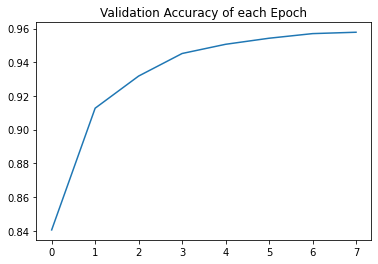

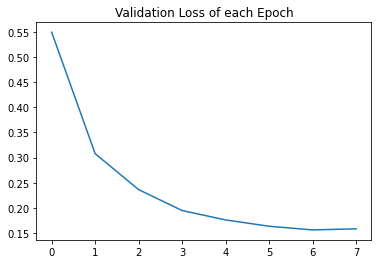

In [11]:
ner = NER(
  model=bilstm,
  data=corpus,
  optimizer_cls=Adam,
  loss_fn_cls=nn.CrossEntropyLoss,
  LR = 0.0004
)
ner.train(8)

**Inference**

Using inference function of ner object, I evaluate qualitative performance of the model. Sentences are randomly generated or taken from news websites.

Most important finding is that right punctuation greatly improve model performance. Additionally, model behaves differently for usage of different unknown words. (euro2020 vs. UEFA)

I also test that if changing size of the model affect inference time, however, there were no significant difference observed.

In [12]:
sentence = "Denmark captain Simon Kjaer congratulated Harry Kane for his win in Euro2020."
tags = ["B-LOC","O","B-PER","I-PER","O","B-PER","I-PER","O","O","O","O","B-ORG","O"]

inf_start_time = time.time()
words, infer_tags, unknown_tokens = ner.infer(sentence=sentence, true_tags=tags)
inf_end_time = time.time()

print(f"Inference time: {inf_end_time-inf_start_time}")

word         	unk          	pred tag	true tag
denmark      	             	B-LOC	B-LOC
captain      	             	O    	O
simon        	             	B-PER	B-PER
kjaer        	✓            	O    	I-PER
congratulated	✓            	O    	O
harry        	✓            	O    	B-PER
kane         	✓            	O    	I-PER
for          	             	O    	O
his          	             	O    	O
win          	             	O    	O
in           	             	O    	O
euro2020     	✓            	O    	B-ORG
.            	             	O    	O
Inference time: 1.2496497631072998


In [13]:
sentence = "Denmark captain Simon Kjaer congratulated his colleague, Harry Kane, for his win in UEFA."
tags = ["B-LOC","O","B-PER","I-PER","O","O","O","O","B-PER","I-PER","O","O","O","O","O","B-MISC","O"]

inf_start_time = time.time()
words, infer_tags, unknown_tokens = ner.infer(sentence=sentence, true_tags=tags)
inf_end_time = time.time()

print(f"Inference time: {inf_end_time-inf_start_time}")

word         	unk          	pred tag	true tag
denmark      	             	B-LOC 	B-LOC
captain      	             	O     	O
simon        	             	B-PER 	B-PER
kjaer        	✓            	I-PER 	I-PER
congratulated	✓            	O     	O
his          	             	O     	O
colleague    	✓            	O     	O
,            	             	O     	O
harry        	✓            	B-PER 	B-PER
kane         	✓            	I-PER 	I-PER
,            	             	O     	O
for          	             	O     	O
his          	             	O     	O
win          	             	O     	O
in           	             	O     	O
uefa         	             	B-MISC	B-MISC
.            	             	O     	O
Inference time: 0.829500675201416


In [14]:
sentence = "President Donald Trump, posted an advert calling on Toyota to stop making donations."
tags = ["O","B-PER", "I-PER","O","O","O","O","O","O","B-ORG","O","O","O","O","O"]

inf_start_time = time.time()
words, infer_tags, unknown_tokens = ner.infer(sentence=sentence, true_tags=tags)
inf_end_time = time.time()

print(f"Inference time: {inf_end_time-inf_start_time}")

word     	unk      	pred tag	true tag
president	         	O     	O
donald   	✓        	B-PER 	B-PER
trump    	✓        	I-PER 	I-PER
,        	         	O     	O
posted   	         	O     	O
an       	         	O     	O
advert   	✓        	O     	O
calling  	         	O     	O
on       	         	O     	O
toyota   	         	B-MISC	B-ORG
to       	         	O     	O
stop     	         	O     	O
making   	         	O     	O
donations	✓        	O     	O
.        	         	O     	O
Inference time: 1.018099308013916


**Future Work**

I failed to implement CRF and character level embeddings using CNN. These two additions would solve most of the problems model suffers.

For example, CRF layer enable model to consider harmony of tags, and it can prevent having outputs like B-I-I-I. Additionally, more recent works uses CNN to generate character level embeddings, and then these embeddings are concatenated with word embeddings to generate final input for LSTM layer. This approach improves model performance especially on unknown words. My implementation is the simplest deep learning based approach.